# The Idea of a Transform

> Utilizing basic functions inside the DataBlock

- toc: true
- badges: true
- comments: true
- image: images/chart-preview.png
- category: DataBlock

---

This blog is also a Jupyter notebook available to run from the top down. There will be code snippets that you can then run in any environment. In this section I will be posting what version of `fastai2` and `fastcore` I am currently running at the time of writing this:


* `fastai2`: 0.0.13

* `fastcore`: 0.1.15
---

## The `DataBlock` API Continued 

This is part two of my series exploring the `DataBlock` API. If you have not read part one, fastai and the New DataBlock API, see [here](https://muellerzr.github.io/fastblog/2020/03/21/DataBlockAPI.html) In it, we discussed the ideas of the `DataBlock` as a whole and how each of the lego-bricks can fit together to help solve some interesting problems. In this next blog, we'll be slowly diving into more complex ideas and uses with it, such as adjusting our `y` values inside of our `get_y`, dealing with classification data seperated by folders (and the splitters we can use)

Also, as a little note, this blog is not explaining the **`Transform`** class, this will come later

From here on we'll be focusing **solely** on generating the `DataLoaders`. Seperate blogs will be made about training the various models. Now, onto the code! As we're still Vision based, we'll use the `vision` sub-library:

In [0]:
from fastai2.vision.all import *

### ImageWoof

[ImageWoof](https://github.com/fastai/imagenette) is a subset of 10 dogs from ImageNet. The idea is that these 10 species of dogs are extremely similar, and so they're hard to classify from scratch. We won't care about that part today, let's go through and see how the data is formatted and apply the `DataBlock`. First let's grab the data:

In [0]:
path = untar_data(URLs.IMAGEWOOF)

Now if we take a look at the `path` first, we'll notice that we have `train` and `val` folders. The two ideas I'll be introducing with this dataset for splitting and labelling are `GrandparentSplitter` and `parent_label`

In [0]:
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2/train'),Path('/root/.fastai/data/imagewoof2/val')]

What do each of these do? I'll go into heavy detail on `fastai`'s splitters and labellers *but* `GrandparentSplitter` operates with the assumption our data is split like ImageNet, where we have training data in a training folder and validation data into a validation folder such as here. Let's make a splitter now by passing in the name of the training folder and the validation folder:

In [0]:
splitter = GrandparentSplitter(train_name='train', valid_name='val')

Let's look at some splits. First we'll grab our list of images then use our `GrandparentSplitter` to seperate out two indicies for us, which we'll then look at to make sure it's working properly

In [0]:
items = get_image_files(path)

In [0]:
splits = splitter(items)

In [0]:
splits[0][0], splits[1][0]

(0, 9025)

Now let's look at images 0 and 9025:

In [0]:
items[0], items[9025]

(Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_15618.JPEG'),
 Path('/root/.fastai/data/imagewoof2/val/n02087394/n02087394_13440.JPEG'))

And we can see that the folders line up!

Now that we have the splitter out of the way, we need a way to get our classes! But what do they look like? We'll look inside the `train` folder at some of the images for some examples:

In [0]:
train_p = path/'train'

In [0]:
train_p.ls()[:3]

(#3) [Path('/root/.fastai/data/imagewoof2/train/n02087394'),Path('/root/.fastai/data/imagewoof2/train/n02115641'),Path('/root/.fastai/data/imagewoof2/train/n02111889')]

In [0]:
items = get_image_files(train_p)[:5]; items

(#5) [Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_15618.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_6198.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_2253.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_7428.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_28267.JPEG')]

We can visualize this folder setup like so:

![](https://i.imgur.com/rv473wC.png)

What this tells us is that our labels are in the folder one level **above** the actual image, or in the `parent` folder (if we consider it like a tree). As such, we can use the `parent_label` function to extract it! Let's look:

In [0]:
labeller = parent_label

In [0]:
labeller(items[0])

'n02087394'

From here we can simply build our `DataBlock` similar to the last post:

In [0]:
blocks = (ImageBlock, CategoryBlock)
item_tfms=[Resize(224)]
batch_tfms=[Normalize.from_stats(*imagenet_stats)]

In [0]:
block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

And make our `DataLoaders`:

In [0]:
dls = block.dataloaders(path, bs=64)

To make sure it all worked out, let's look at a batch:

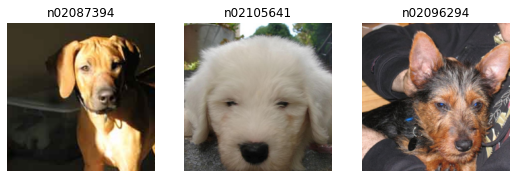

In [0]:
dls.show_batch(max_n=3)

## The idea of a `transform`

Now we're still going to use the ImageWoof dataset here, but I want to introduce you to the concept of a `transform`. From an outside perspective and what we've seen so far, this is normally limited to what we would call "augmentation." With the new `fastai` this is **no longer the case**. Instead, let's think of a transform as "any modification we can apply to our data at any point in time." 

But what does that really mean? What *is* a transform? A function! Any transform can be written out as a simple function that we pass in at any moment. 

What do I mean by this though? Let's take a look at those labels again. If we notice, we see bits like:

In [0]:
labeller(items[0]), labeller(items[1200])

('n02087394', 'n02115641')

But that has no actual meaning to us (or anyone else reading to what we are doing). Let's use a `transform` that will change this into something readable. 

First we'll build a dictionary that keeps track of what each original class name means:

In [0]:
lbl_dict = dict(n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

Now to use this as a function, we need a way to look into the dictionary with any *raw* input and return back our string. This can be done via the `__getitem__` function:

In [0]:
lbl_dict.__getitem__(labeller(items[0]))

'Rhodesian ridgeback'

Looks readable enough now, right? So where do I put this into the API. We can stack these mini-transforms anywhere we'd like them applied. For instance here, we want it done on our `get_y`, but *after* `parent_label` has been applied. Let's do that:

In [0]:
block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=[parent_label, lbl_dict.__getitem__],
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

In [0]:
dls = block.dataloaders(path, bs=64)

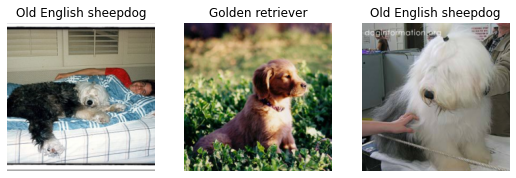

In [0]:
dls.show_batch(max_n=3)

Awesome! It worked, and that was **super** simple. Does the order matter here though? Let's try reversing it:

In [0]:
block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=[lbl_dict.__getitem__, parent_label],
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

In [0]:
dls = block.dataloaders(path, bs=64)

![image.png](https://i.imgur.com/8VVt1nk.png)

Oh no, I got an error! What is it telling me? That I was passing in the full image path to the dictionary *before* we extracted the `parent_label`, so order **does** matter in how you place these functions! Further, these functions can go in any of the building blocks for the `DataBlock` **except** during data augmentation (as these require special modifications we'll look at later). 